### Comparison between Crank-Nicolson method for solving the 1-D diffusion equation in Spherical and Cartesian coordinates 

This employs a Crank-Nicolson (CN) method to numerically solve the 1 dimensional diffusion equation in both Spherical and Cartesian coordinates:

#### $\frac{\partial X}{\partial t} = D\nabla^{2}X$

where X is some scalar field and D is the diffusion constant.

The solution is unconditionally stable and the code ensure that it is accurate based on a Von-Neumann stability analysis: $\frac{\kappa dt}{2dr^{2}}<0.5$ (running multiple iterations at smaller dt if necessary)

Either a fixed value or Nuemann boundary condition may be used for either boundary. To use the code, simply run the cells in order, where the last cell can be modified for the specific intial and boundary conditions of interest.

Created by Sam Greenwood



In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# SPHERICAL CN
###############################################################################  
def diffusion_sph(X,r,dt,lb,ub,kappa,gp1,gp2):

    #Define m for given dt,kappa and dr.
    dr = r[1]-r[0]
    m = kappa*dt/(2*dr**2)
    n = 1
    tolerance = 0.4

    #Repeat calculation at a smaller dt if necessary to ensure accuracy 
    if m >= 0.5:
        n = int(np.ceil(m/tolerance))
        dt = dt/n
        m = m/n

    A = LHS_lin_eq1(r,dr,m,gp1,gp2)

    #Solve for internal Temperatures   
    for i in range(n):
        B = RHS_lin_eq1(X,r,dr,m,gp1,gp2,lb,ub)
        X = np.linalg.solve(A,B)

    return X

###############################################################################
############################################################################### 
def RHS_lin_eq1(X,r,dr,m,gp1,gp2,lb,ub):
    #Set up linear algebra equations in the form Ax=B


    size = r.size
    B = np.zeros(size)

    for i in range(1,size-1):
        B[i] = m*(1 - dr/r[i])*X[i-1] + (1-2*m)*X[i] + m*(1 + dr/r[i])*X[i+1]

    if gp1 == 1:
        B[0]=(1-2*m)*X[0] + 2*m*X[1] + 2*m*dr*(lb+lb)*(dr/r[0] - 1)
    else:
        B[0] = lb

    if gp2 == 1:
        B[-1]=(2*m)*X[-2] + (1-2*m)*X[-1] + 2*m*dr*(ub+ub)*(1+ dr/r[-1])
    else:
        B[-1] = ub

    return B
###############################################################################
###############################################################################      
def LHS_lin_eq1(r,dr,m,gp1,gp2):
    #Set up linear algebra equations in the form Ax=B

    size = r.size
    A = np.zeros([size,size])

    for i in range(1,size-1):
        A[i,i] = (1+2*m)

        A[i,i-1] = m*(dr/r[i] - 1)

        A[i,i+1] = m*(-1 -dr/r[i])


    if gp1 == 1:
        A[0,1] = -2*m
        A[0,0] = (1+2*m)
    elif gp1 == 0:
        A[0,0] = 1

    if gp2 == 1:
        A[-1,-2] = -2*m
        A[-1,-1] = (1+2*m)
    elif gp2 == 0:
        A[-1,-1] = 1

    return A
###############################################################################

In [22]:
# CARTESIAN CN
###############################################################################  
def diffusion_cart(X,r,dt,lb,ub,kappa,gp1,gp2):

    #Define m for given dt,kappa and dr.
    dr = r[1]-r[0]
    m = kappa*dt/(2*dr**2)
    n = 1
    tolerance = 0.4

    #Repeat calculation at a smaller dt if necessary to ensure accuracy 
    if m >= 0.5:
        n = int(np.ceil(m/tolerance))
        dt = dt/n
        m = m/n
        
    A = LHS_lin_eq2(r.size,m,gp1,gp2)

    #Solve for internal Temperatures   
    for i in range(n):
        B = RHS_lin_eq2(X,dr,m,gp1,gp2,lb,ub)
        X = np.linalg.solve(A,B)

    return X

###############################################################################
############################################################################### 
def RHS_lin_eq2(X,dr,m,gp1,gp2,lb,ub):
    #Set up linear algebra equations in the form Ax=B

    size = X.size
    B = np.zeros(size)

    for i in range(1,size-1):
        B[i] = m*X[i-1] + (1-2*m)*X[i] + m*X[i+1]

    if gp1 == 1:
        B[0]=(1-2*m)*X[0] + 2*m*X[1] - 2*m*dr*(lb+lb)
    else:
        B[0] = lb

    if gp2 == 1:
        B[-1]=(2*m)*X[-2] + (1-2*m)*X[-1] + 2*m*dr*(ub+ub)
    else:
        B[-1] = ub

    return B
###############################################################################
###############################################################################      
def LHS_lin_eq2(size,m,gp1,gp2):
    #Set up linear algebra equations in the form Ax=B

    A = np.zeros([size,size])

    for i in range(1,size-1):
        A[i,i] = (1+2*m)

        A[i,i-1] = -m

        A[i,i+1] = -m


    if gp1 == 1:
        A[0,1] = -2*m
        A[0,0] = (1+2*m)
    elif gp1 == 0:
        A[0,0] = 1

    if gp2 == 1:
        A[-1,-2] = -2*m
        A[-1,-1] = (1+2*m)
    elif gp2 == 0:
        A[-1,-1] = 1

    return A
###############################################################################

In [23]:
# Analytical Solution from Gubbins and Davies (2013)
###############################################################################
from math import erfc
def barodiffusion(D,b,t,r,c):

    h = np.sqrt(D*t)
    y = r[-1]-r[0]
    for i in range(len(r)):
        if i>0:
            dy = r[i] - r[i-1]
        else:
            dy=0

        y = y - dy

        zeta = y/(2*h)

        t1 = np.exp(-(zeta**2))/np.sqrt(np.pi)
        t2 = zeta*erfc(zeta)

        c[i] = c[i] + 2*b*h*(t1-t2)

    return c
###############################################################################
#Gubbins, D. and Davies, C. 2013. The stratified layer at the core-mantle boundary caused by
#barodiffusion of oxygen, sulphur and silicon. Physicss of the Earth and Planetary Interiors.
#215, pp 21-28
###############################################################################

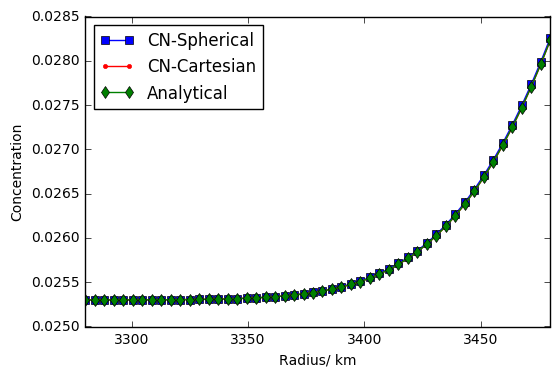

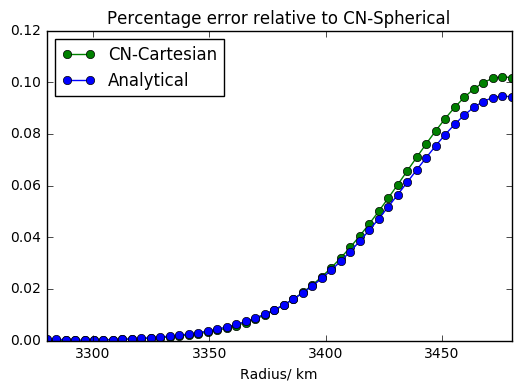

In [24]:
#Initialise Grid and value of scalar field across it (must be uniform grid)
r = np.linspace(3280e3,3480e3,50)
c = np.ones(r.size)*0.0253

#Diffusion Constant (m^2/s) and time step (s)
D = 1e-8
dt = 60*60*24*365*4.6e9

#Lower (lb) and Upper (ub) Boundary Condition Values
alpha_c = 1.1
alpha_D = 0.62e-12
g_prime = 10/3480e3
r_o = 3480e3
rho = 10000
b = alpha_c*alpha_D*g_prime*r_o/(rho*D)

lb = c[0]
ub = b

#Boundary Condition Type (0=Fixed Value, 1=Fixed Gradient)
lb_type = 0
ub_type = 1

#Calculate the solutions
c1 = diffusion_sph(c,r,dt,lb,ub,D,lb_type,ub_type)
c2 = diffusion_cart(c,r,dt,lb,ub,D,lb_type,ub_type)
c3 = barodiffusion(D,b,dt,r,c)

#Plot result in km
r = r/1000

#Plot the results
plt.plot(r,c1,'b-s')
plt.plot(r,c2,'r.-')
plt.plot(r,c3,'gd-')
plt.xlabel('Radius/ km')
plt.xlim([r[0],r[-1]])
plt.legend(['CN-Spherical','CN-Cartesian','Analytical'],loc=0)
plt.ylabel('Concentration')
plt.show()


plt.plot(r,100*np.abs(c2-c1)/c1,'g-o')
plt.plot(r,100*np.abs(c3-c1)/c1,'b-o')
plt.xlabel('Radius/ km')
plt.xlim([r[0],r[-1]])
plt.title('Percentage error relative to CN-Spherical')
plt.legend(['CN-Cartesian','Analytical'],loc=0)
plt.show()

